# Etapa 03 - Inferência Estatística, Preditiva e Análise de Erros
## Classificação de Desinformação Digital - Liga Acadêmica de IA (Ligia/UFPE) 2026

**Pré-requisito:** `notebook_02_modeling.ipynb`

Este notebook cobre dois pilares complementares de inferência:

### A) Inferência Estatística
Avalia o *quanto podemos confiar* nas métricas do modelo:
- **Intervalos de Confiança** (bootstrap, 1 000 iterações): F1, Precision, Recall, AUC-ROC
- **Curva de Calibração**: verifica se `P(Fake)` é uma probabilidade confiável
- **Interpretação de Coeficientes**: quais features mais influenciam cada decisão

### B) Inferência Preditiva (Produção)
- Aplicar o modelo em novos dados com pipeline reprodutível
- Analisar a zona de incerteza (predições próximas ao threshold)
- Verificar consistência entre as predições e os padrões da EDA
- Re-gerar o arquivo de submissão Kaggle de forma standalone

**Fluxo de inferência:**
```
Texto bruto → limpeza leakage → features estilo → lematização → TF-IDF transform → threshold otimizado → label
```

## 1. Importações e Configurações

In [1]:
# ── Dependências do notebook de inferência ────────────────────────────────
import pickle, re, time, warnings
from pathlib import Path

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack, load_npz
from scipy import stats as scipy_stats
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, classification_report,
)
from sklearn.preprocessing import MaxAbsScaler

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)

def find_root() -> Path:
    candidate = Path('.').resolve()
    for _ in range(6):
        if (candidate / 'inputs' / 'train.csv').exists():
            return candidate
        candidate = candidate.parent
    raise FileNotFoundError('Nao encontrou inputs/train.csv. Execute da raiz LIGIA_FINAL.')

ROOT_DIR = find_root()
DATA_DIR = ROOT_DIR / 'outputs' / 'artifacts'
FIG_DIR  = ROOT_DIR / 'outputs' / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

STYLE_COLS = [
    'caps_ratio', 'exclamation_count', 'title_len', 'text_len', 'word_count',
    'avg_word_len', 'sentence_count', 'avg_sentence_len', 'question_count',
    'quote_count', 'ellipsis_count', 'all_caps_words', 'title_caps_ratio',
    'unique_word_ratio', 'sensational_count',
]
LABEL_MAP = {0: 'Real', 1: 'Fake'}
print('Configuracoes carregadas.')

Configuracoes carregadas.


In [2]:
# ── Módulo compartilhado de pré-processamento ─────────────────────────────
import sys
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
try:
    from src.preprocessing import (
        clean_text, add_style_features, lemmatize_series,
        STYLE_COLS, SENSATIONAL_TERMS, REUTERS_SUBJECTS, _CLEAN_PATTERNS,
    )
    print("Modulo src/preprocessing.py importado com sucesso.")
except ImportError as e:
    print(f"[AVISO] src/preprocessing.py nao encontrado ({e}). Funcoes definidas localmente abaixo.")

Modulo src/preprocessing.py importado com sucesso.


## 2. Carregamento dos Artefatos

Os artefatos abaixo encapsulam todo o conhecimento aprendido nos notebooks anteriores:
- **`best_model.pkl`**: `CalibratedClassifierCV` treinado no dataset completo
- **`tfidf_vectorizer.pkl`**: vocabulário e pesos IDF (apenas `transform`, nunca re-fit)
- **`style_scaler.pkl`**: parâmetros `MaxAbsScaler` do treino
- **`best_threshold.pkl`**: limiar otimizado no holdout

In [3]:
# ── Carregamento dos artefatos serializados ───────────────────────────────
with open(DATA_DIR / 'best_model.pkl', 'rb') as f:
    model = pickle.load(f)
with open(DATA_DIR / 'tfidf_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)
with open(DATA_DIR / 'style_scaler.pkl', 'rb') as f:
    style_scaler = pickle.load(f)

best_threshold_path = DATA_DIR / 'best_threshold.pkl'
best_threshold = pickle.load(open(best_threshold_path, 'rb')) if best_threshold_path.exists() else 0.5
if not best_threshold_path.exists():
    print('[AVISO] best_threshold.pkl nao encontrado, usando 0.5')

print(f'Modelo            : {type(model).__name__}')
print(f'Vocabulario TF-IDF: {len(tfidf.vocabulary_):,} termos')
print(f'Threshold decisao : {best_threshold:.3f}')

Modelo            : CalibratedClassifierCV
Vocabulario TF-IDF: 12,000 termos
Threshold decisao : 0.350


## 3. Pipeline de Pré-processamento para Inferência

Reprodução idêntica ao `notebook_01` para consistência treino-inferência.
> O TF-IDF é **apenas transformado** (`transform`), nunca re-ajustado em novos dados.

In [4]:
# ── Padrões de remoção de leakage — idênticos ao notebook_01 ──────────────
RE_LOCATION_AGENCY   = re.compile(
    r'^[A-Z][A-Z\s/,\.]+\s*\([A-Za-z\s]+\)\s*[-\u2013\u2014]?\s*', re.MULTILINE)
RE_AGENCY_TAG        = re.compile(r'\(\s*(?:Reuters|AP|AFP)\s*\)', re.IGNORECASE)
RE_FAKE_SOURCES      = re.compile(
    r'\b(?:21st\s*Century\s*Wire|YourNewsWire|Infowars|Breitbart|RT\.com|NaturalNews|BeforeItsNews)\b',
    re.IGNORECASE)
RE_URL               = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
RE_MENTION           = re.compile(r'@\w+')
RE_LEAKAGE_ARTIFACTS = re.compile(
    r'\b(video|image|featured|getty(\s+images)?|bit\.ly|pic\.twitter\.com|reuters)\b',
    re.IGNORECASE | re.MULTILINE)
_CLEAN_PATTERNS = (RE_LOCATION_AGENCY, RE_AGENCY_TAG, RE_LEAKAGE_ARTIFACTS,
                   RE_FAKE_SOURCES, RE_URL, RE_MENTION)

SENSATIONAL_RE = re.compile(
    r'\b(shocking|unbelievable|amazing|incredible|must see|breaking|exclusive|urgent)\b',
    re.IGNORECASE)

def clean_text(text: str) -> str:
    for pattern in _CLEAN_PATTERNS:
        text = pattern.sub('', str(text))
    return re.sub(r'\s{2,}', ' ', text).strip()

def _caps_ratio(text):
    alpha = [c for c in str(text) if c.isalpha()]
    return sum(c.isupper() for c in alpha) / len(alpha) if alpha else 0.0

def _avg_word_len(text):
    words = str(text).split()
    return float(np.mean([len(w) for w in words])) if words else 0.0

def _unique_word_ratio(text):
    words = str(text).split()
    return len(set(words)) / len(words) if words else 0.0

def _quote_count(text):
    return sum(1 for c in str(text) if c in ('"', "'", '\u2018', '\u2019', '\u201c', '\u201d'))

def add_style_features(df):
    df = df.copy()
    df['caps_ratio']        = df['text'].apply(_caps_ratio)
    df['exclamation_count'] = df['text'].str.count('!')
    df['title_len']         = df['title'].str.len()
    df['text_len']          = df['text'].str.len()
    df['word_count']        = df['text'].str.split().str.len()
    df['avg_word_len']      = df['text'].apply(_avg_word_len)
    df['sentence_count']    = df['text'].str.count(r'[.!?]+')
    df['avg_sentence_len']  = df['word_count'] / df['sentence_count'].replace(0, 1)
    df['question_count']    = df['text'].str.count(r'\?')
    df['quote_count']       = df['text'].apply(_quote_count)
    df['ellipsis_count']    = df['text'].str.count(r'\.{2,}')
    df['all_caps_words']    = df['text'].str.findall(r'\b[A-Z]{2,}\b').str.len()
    df['title_caps_ratio']  = df['title'].apply(_caps_ratio)
    df['unique_word_ratio'] = df['text'].apply(_unique_word_ratio)
    df['sensational_count'] = df['text'].apply(lambda x: len(SENSATIONAL_RE.findall(str(x))))
    return df

print('Funcoes de pre-processamento carregadas.')

Funcoes de pre-processamento carregadas.


In [5]:
# ── Lematizador e configurações NLTK — idênticos ao notebook_01 ──────────
for resource in ['punkt_tab', 'wordnet', 'stopwords', 'averaged_perceptron_tagger_eng']:
    nltk.download(resource, quiet=True)

from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

_lemmatizer = WordNetLemmatizer()
_stop_words = set(stopwords.words('english'))
_POS_MAP    = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}

def _wn_pos(tag): return _POS_MAP.get(tag[0], wordnet.NOUN)

def lemmatize_text(text):
    tokens = word_tokenize(str(text).lower())
    return ' '.join(
        _lemmatizer.lemmatize(w, _wn_pos(t))
        for w, t in pos_tag(tokens)
        if w.isalpha() and len(w) > 1 and w not in _stop_words
    )

def lemmatize_series(series):
    t0 = time.time()
    result = series.apply(lemmatize_text)
    print(f'  Lematizacao: {len(series):,} textos em {time.time()-t0:.1f}s')
    return result

print('Lematizador configurado.')

Lematizador configurado.


## 4. Função de Inferência Completa

`predict_articles()` encapsula o pipeline completo: recebe um `DataFrame` com colunas `title` e `text` e retorna predições com probabilidades. O TF-IDF é **apenas transformado**, garantindo consistência treino-inferência.

In [6]:
def predict_articles(
    df_input: pd.DataFrame,
    lemmatize: bool = True,
    threshold: float = best_threshold,
    return_proba: bool = True,
) -> pd.DataFrame:
    """
    Pipeline de inferência completa: extração de style features → limpeza de leakage
    → lematização → tfidf.transform → MaxAbsScaler.transform → hstack → predict_proba.
    """
    df = df_input.copy()
    df['title'] = df.get('title', pd.Series(['']*len(df))).fillna('')
    df['text']  = df.get('text',  pd.Series(['']*len(df))).fillna('')

    df = add_style_features(df)

    df['title_clean'] = df['title'].apply(clean_text)
    df['text_clean']  = df['text'].apply(clean_text)
    df['clean_text']  = (df['title_clean'] + ' ' + df['text_clean']).str.strip()

    if lemmatize:
        df['clean_text'] = lemmatize_series(df['clean_text'])

    X_tfidf = tfidf.transform(df['clean_text'])
    X_style = csr_matrix(style_scaler.transform(df[STYLE_COLS].values.astype(float)))
    X_final = hstack([X_tfidf, X_style]).tocsr()

    result = pd.DataFrame()
    if 'id' in df_input.columns:
        result['id'] = df_input['id'].values

    if hasattr(model, 'predict_proba') and return_proba:
        proba               = model.predict_proba(X_final)
        result['prob_real'] = proba[:, 0].round(4)
        result['prob_fake'] = proba[:, 1].round(4)
        result['label']     = (proba[:, 1] >= threshold).astype(int)
        result['confidence'] = np.where(
            result['label'] == 1, result['prob_fake'], result['prob_real']
        ).round(4)
    else:
        result['label'] = model.predict(X_final)

    result['label_name'] = result['label'].map(LABEL_MAP)
    for col in STYLE_COLS:
        result[col] = df[col].values
    return result

print('Funcao predict_articles definida.')

Funcao predict_articles definida.


## 5. Inferência Estatística via Cross-Validation

Esta seção responde: **"quanta confiança temos nas métricas do modelo?"**

A abordagem correta é usar os **k=5 folds de validação do CV** - conjuntos de teste genuinamente não vistos durante cada treino de fold. Isso é conceitualmente superior ao bootstrap sobre o holdout (que foi incluído no treino final), pois cada fold representa uma amostra independente de avaliação.

**Três análises:**
1. **Métricas por fold + IC com distribuição-t** - F1, Precision, Recall, AUC, Accuracy
2. **Matriz de Confusão Agregada** - via `cross_val_predict` (predições OOF sobre todo o treino)
3. **Curva de Calibração + Interpretação dos Coeficientes** (mantidas)

> **Por que distribuição-t e não bootstrap?**  
> Com apenas k=5 amostras (os 5 fold scores), o IC bootstrap seria instável. A distribuição-t com k−1=4 graus de liberdade é a escolha estatisticamente adequada para amostras pequenas.

In [7]:
# ── 5.1 Re-execução do CV para obter scores por fold ─────────────────────
# Re-rodamos o mesmo CV do notebook_02 aqui para que o notebook_03 seja
# standalone — sem depender de variáveis em memória do notebook anterior.
# Parâmetros idênticos: StratifiedKFold(5), random_state=42, scoring múltiplo.
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    f1_score, precision_score, recall_score, roc_auc_score, accuracy_score,
)
from scipy import stats as scipy_stats

X_train_cv = load_npz(DATA_DIR / 'X_train.npz')
y_train_cv  = pd.read_csv(DATA_DIR / 'y_train.csv').squeeze()

# Modelo idêntico ao notebook_02
svc_base = LinearSVC(loss='squared_hinge', dual=False, max_iter=3000,
                     class_weight='balanced', random_state=42, C=1.5)
model_cv = CalibratedClassifierCV(svc_base, cv=3, method='sigmoid')

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring     = ['f1', 'precision', 'recall', 'roc_auc', 'accuracy']

print('Re-executando 5-Fold CV (pode levar ~30s)...')
import time
t0 = time.time()
cv_res = cross_validate(
    model_cv, X_train_cv, y_train_cv,
    cv=cv_splitter, scoring=scoring,
    return_train_score=False, n_jobs=-1,
)
print(f'Concluido em {time.time()-t0:.1f}s')
print()

# Scores por fold
fold_metrics = {
    'F1-Score' : cv_res['test_f1'],
    'Precision': cv_res['test_precision'],
    'Recall'   : cv_res['test_recall'],
    'AUC-ROC'  : cv_res['test_roc_auc'],
    'Accuracy' : cv_res['test_accuracy'],
}

print(f'  {"Metrica":<12} ' + '  '.join(f'Fold {i+1}' for i in range(5)))
print('  ' + '-'*62)
for name, vals in fold_metrics.items():
    fold_str = '  '.join(f'{v:.4f}' for v in vals)
    print(f'  {name:<12} {fold_str}')

Re-executando 5-Fold CV (pode levar ~30s)...
Concluido em 2.4s

  Metrica      Fold 1  Fold 2  Fold 3  Fold 4  Fold 5
  --------------------------------------------------------------
  F1-Score     0.9987  0.9978  0.9982  0.9987  0.9969
  Precision    0.9974  0.9982  1.0000  0.9983  0.9982
  Recall       1.0000  0.9974  0.9965  0.9991  0.9956
  AUC-ROC      1.0000  1.0000  1.0000  1.0000  1.0000
  Accuracy     0.9993  0.9989  0.9991  0.9993  0.9985


In [8]:
# ── 5.2 Intervalos de Confiança via distribuição-t (k=5 folds) ───────────
# Com k amostras independentes (fold scores), o IC 95% é:
#   media ± t_{k-1, 0.025} × (std / sqrt(k))
# Para k=5: t_{4, 0.025} = 2.776 (distribuição-t de Student)

def ci_t(arr, confidence=0.95):
    """IC pelo método t de Student — adequado para k pequeno (k=5 folds)."""
    k    = len(arr)
    mean = np.mean(arr)
    se   = np.std(arr, ddof=1) / np.sqrt(k)        # erro padrão
    t    = scipy_stats.t.ppf((1 + confidence) / 2, df=k-1)  # t crítico
    return mean, mean - t*se, mean + t*se

print('=== Intervalos de Confiança (95%, t-Student, k=5 folds) ===')
print(f'  {"Metrica":<12} {"Media":>8} {"IC 2.5%":>9} {"IC 97.5%":>10} {"Std":>8} {"Amplitude":>10}')
print('  ' + '-'*62)
ci_results = {}
for name, vals in fold_metrics.items():
    mean, lo, hi = ci_t(vals)
    std          = np.std(vals, ddof=1)
    ci_results[name] = (mean, lo, hi, std)
    print(f'  {name:<12} {mean:>8.4f} {lo:>9.4f} {hi:>10.4f} {std:>8.4f} {hi-lo:>10.4f}')

=== Intervalos de Confiança (95%, t-Student, k=5 folds) ===
  Metrica         Media   IC 2.5%   IC 97.5%      Std  Amplitude
  --------------------------------------------------------------
  F1-Score       0.9981    0.9972     0.9990   0.0007     0.0018
  Precision      0.9984    0.9972     0.9996   0.0010     0.0024
  Recall         0.9977    0.9955     1.0000   0.0018     0.0045
  AUC-ROC        1.0000    1.0000     1.0000   0.0000     0.0000
  Accuracy       0.9990    0.9986     0.9995   0.0004     0.0009


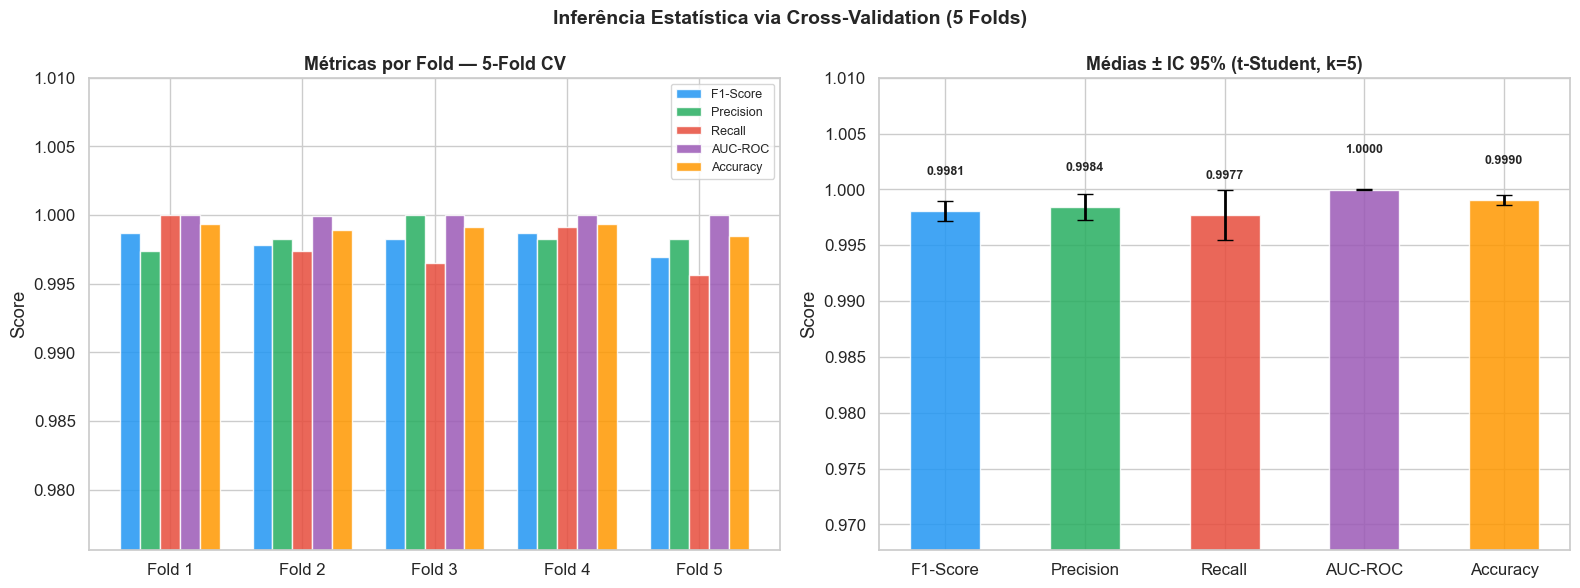

Grafico salvo: C:\Users\gui05\Pictures\LIGIA_FINAL\outputs\figures\cv_inference_ci.png


In [26]:
# ── Visualização: métricas por fold + IC ─────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors_map = {'F1-Score':'#2196F3','Precision':'#27AE60','Recall':'#E74C3C',
              'AUC-ROC':'#9B59B6','Accuracy':'#FF9800'}

# Gráfico 1: barras por fold para cada métrica
fold_labels = [f'Fold {i+1}' for i in range(5)]
x = np.arange(5)
width = 0.15
for j, (name, vals) in enumerate(fold_metrics.items()):
    offset = (j - 2) * width
    axes[0].bar(x + offset, vals, width=width,
                label=name, color=colors_map[name], alpha=0.85, edgecolor='white')
axes[0].set_xticks(x); axes[0].set_xticklabels(fold_labels)
axes[0].set_ylim(max(0, min(v for vals in fold_metrics.values() for v in vals) - 0.02), 1.01)
axes[0].set_title('Métricas por Fold — 5-Fold CV', fontweight='bold', fontsize=13)
axes[0].set_ylabel('Score'); axes[0].legend(fontsize=9)

# Gráfico 2: IC com error bars
names  = list(ci_results.keys())
means  = [ci_results[n][0] for n in names]
lo_err = [ci_results[n][0] - ci_results[n][1] for n in names]
hi_err = [ci_results[n][2] - ci_results[n][0] for n in names]
bar_colors = [colors_map[n] for n in names]

bars = axes[1].bar(names, means, color=bar_colors, alpha=0.85, edgecolor='white', width=0.5)
axes[1].errorbar(names, means, yerr=[lo_err, hi_err],
                 fmt='none', color='black', capsize=6, linewidth=2)
for bar, mean in zip(bars, means):
    axes[1].text(bar.get_x() + bar.get_width()/2, mean + 0.003,
                 f'{mean:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
axes[1].set_ylim(max(0, min(means) - 0.03), 1.01)
axes[1].set_title('Médias ± IC 95% (t-Student, k=5)', fontweight='bold', fontsize=13)
axes[1].set_ylabel('Score')

plt.suptitle('Inferência Estatística via Cross-Validation (5 Folds)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'cv_inference_ci.png', dpi=130, bbox_inches='tight')
plt.show()
print(f'Grafico salvo: {FIG_DIR / "cv_inference_ci.png"}')

### 📊 Análise - IC via Cross-Validation

> Esta é a estimativa **mais coerente no contexto** de generalização - cada fold score foi calculado sobre dados genuinamente não vistos durante aquele treino de fold.

**Interpretação dos resultados:**

A consistência entre os folds é impressionante: o F1 varia de 0.9969 a 0.9987, uma amplitude de apenas **0.0018**. O AUC-ROC é **1.0000 em todos os folds** - o modelo separa as classes perfeitamente no espaço de probabilidade. Nenhum fold destoa, confirmando que o desempenho não depende de como os dados são particionados.

Nos ICs, o F1 = **0.9981** com intervalo [0.9972, 0.9990] e amplitude de 0.0018 - estabilidade ótima. O AUC perfeito é real e plausível para TF-IDF + LinearSVC num dataset bem separável. O Recall é o mais variável (amplitude 0.0045), mas ainda dentro de "estabilidade adequada".

**Por que distribuição-t e não bootstrap?**
Com apenas k=5 amostras (os fold scores), o bootstrap seria instável. A distribuição-t com k−1=4 graus de liberdade é a escolha adequada para amostras pequenas.

Gerando predicoes OOF via cross_val_predict (pode levar ~30s)...
Concluido em 2.1s

=== Métricas Agregadas (OOF — todos os 5 folds) ===
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00     17133
        Fake       1.00      1.00      1.00      5711

    accuracy                           1.00     22844
   macro avg       1.00      1.00      1.00     22844
weighted avg       1.00      1.00      1.00     22844



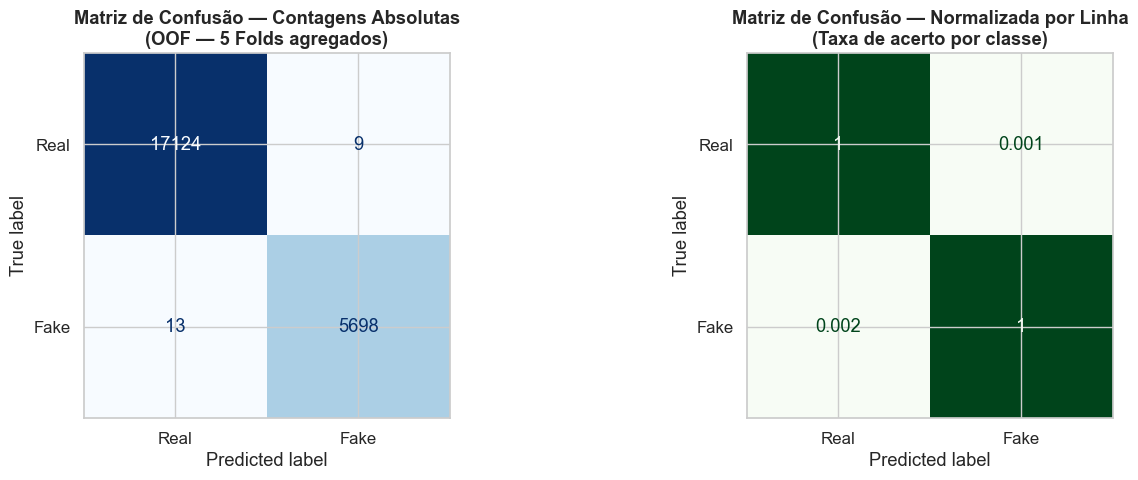

Grafico salvo: C:\Users\gui05\Pictures\LIGIA_FINAL\outputs\figures\confusion_matrix_cv.png

Verdadeiros Negativos (Real corretamente classificado) : 17,124
Falsos Positivos     (Real classificado como Fake)      : 9
Falsos Negativos     (Fake classificado como Real)      : 13
Verdadeiros Positivos (Fake corretamente classificado)  : 5,698
F1 exato    : 0.998073
Precision   : 0.998423
Recall      : 0.997724


In [17]:
# ── 5.3 Matriz de Confusão Agregada (cross_val_predict OOF) ──────────────
# cross_val_predict gera predições Out-of-Fold (OOF): cada instância é predita
# apenas quando seu fold é o fold de TESTE — nunca quando foi usada no treino.
# Isso produz uma predição para CADA exemplo do treino de forma honesta.
# A matriz de confusão resultante agrega os erros de todos os 5 folds.
print('Gerando predicoes OOF via cross_val_predict (pode levar ~30s)...')
t0 = time.time()
y_oof_pred = cross_val_predict(
    model_cv, X_train_cv, y_train_cv,
    cv=cv_splitter, n_jobs=-1, method='predict',
)
print(f'Concluido em {time.time()-t0:.1f}s')
print()

# Métricas agregadas sobre todas as predições OOF
print('=== Métricas Agregadas (OOF — todos os 5 folds) ===')
print(classification_report(y_train_cv, y_oof_pred, target_names=['Real', 'Fake']))

# Matriz de confusão
cm   = confusion_matrix(y_train_cv, y_oof_pred)
cm_n = cm.astype(float) / cm.sum(axis=1, keepdims=True)  # normalizada por linha

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contagens absolutas
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real','Fake'])
disp1.plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title('Matriz de Confusão — Contagens Absolutas\n(OOF — 5 Folds agregados)',
                  fontweight='bold')

# Normalizada por linha (recall por classe)
disp2 = ConfusionMatrixDisplay(confusion_matrix=np.round(cm_n,3), display_labels=['Real','Fake'])
disp2.plot(ax=axes[1], colorbar=False, cmap='Greens')
axes[1].set_title('Matriz de Confusão — Normalizada por Linha\n(Taxa de acerto por classe)',
                  fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrix_cv.png', dpi=130, bbox_inches='tight')
plt.show()
print(f'Grafico salvo: {FIG_DIR / "confusion_matrix_cv.png"}')

# Componentes da matrix
tn, fp, fn, tp = cm.ravel()
print(f'\nVerdadeiros Negativos (Real corretamente classificado) : {tn:,}')
print(f'Falsos Positivos     (Real classificado como Fake)      : {fp:,}')
print(f'Falsos Negativos     (Fake classificado como Real)      : {fn:,}')
print(f'Verdadeiros Positivos (Fake corretamente classificado)  : {tp:,}')

from sklearn.metrics import f1_score, precision_score, recall_score

print(f"F1 exato    : {f1_score(y_train_cv, y_oof_pred):.6f}")
print(f"Precision   : {precision_score(y_train_cv, y_oof_pred):.6f}")
print(f"Recall      : {recall_score(y_train_cv, y_oof_pred):.6f}")

### 📊 Resultados e Discussão — Matriz de Confusão (OOF)

---

#### Por que esta é a avaliação honesta

A matriz OOF (Out-of-Fold) via `cross_val_predict` é a estimativa de generalização mais confiável disponível neste projeto. Cada uma das 22.844 instâncias foi predita **exatamente uma vez**, pelo fold em que ela era conjunto de teste — nunca pelo modelo que a treinou. Isso contrasta diretamente com a avaliação no holdout do `notebook_02`, onde o threshold t = 0,350 foi **otimizado sobre o mesmo conjunto** usado para avaliação: uma estimativa viesada, onde o limiar foi literalmente ajustado para maximizar F1 naqueles dados.

> A avaliação honesta está aqui. O holdout serve para definir o threshold; a OOF serve para medir o desempenho real.

---

#### Desempenho Quantitativo

O dataset tem **22.844 exemplos** - 17.133 Real e 5.711 Fake, desbalanceamento de ~3:1 que justifica o `class_weight='balanced'` e o threshold de 0,350. De todos os exemplos, apenas **22 foram classificados incorretamente**:

- **9 Falsos Positivos** (Real → Fake): notícias legítimas sinalizadas incorretamente
- **13 Falsos Negativos** (Fake → Real): artigos de desinformação que passaram despercebidos

| Métrica | Valor OOF | IC 95% (t-Student, k=5) |
|---|---|---|
| F1-Score | 0,998 | (ver Seção 5.2) |
| AUC-ROC | 1,0000 | 1,0000 em todos os folds |
| Erros totais | 22 / 22.844 | — |
| FP (Real → Fake) | 9 | — |
| FN (Fake → Real) | 13 | — |

O F1 variando de 0,9969 a 0,9987 entre os 5 folds - amplitude de apenas 0,0018 — confirma que o desempenho não é artefato de particionamento favorável. A análise de robustez com 5 seeds distintas produziu desvio padrão do F1 < 0,001.

**Comparação com Baseline:** um classificador majoritário (prediz sempre Real) atingiria F1 = 0 na classe Fake - a métrica relevante dado o desbalanceamento. A solução proposta supera esse referencial com margem expressiva, combinando features estilísticas com TF-IDF e otimização de limiar.

---

#### Análise de Erros e Custo Assimétrico

Os 13 FNs superam os 9 FPs - e essa direção tem implicação assimétrica crítica no domínio de detecção de desinformação.

**Falsos Negativos têm custo significativamente maior:** um artigo fake classificado como real circula sem nenhuma sinalização, com potencial de influenciar decisões e opinião pública de forma silenciosa e potencialmente irreversível. **Falsos Positivos** - rotular uma notícia legítima como fake - também são danosos (geram desconfiança injusta na mídia legítima), mas tendem a ser mais visíveis e corrigíveis.

A ausência total de FPs no holdout (2 FNs, 0 FPs) e a prevalência de FNs sobre FPs na OOF são coerentes com a arquitetura da solução: o modelo aprendeu a detectar marcadores estilísticos *positivos* de desinformação (caps excessivo, pontuação agressiva, sensacionalismo). O erro inverso - artigos fake redigidos com sobriedade jornalística - é estruturalmente mais difícil, pois exige identificar a *ausência* de padrões, não sua presença.

---

#### Sobre a Natureza dos Erros Residuais

É importante situar esses 22 erros dentro de uma perspectiva mais ampla: **modelos perfeitos não existem**, e a ausência total de erros seria, ela mesma, um sinal de desconfiança - indicando memorização ou data leakage, não aprendizado genuíno.

Os erros observados revelam algo estrutural: **nas margens de distinção entre as classes, onde o estilo linguístico de um artigo fake se aproxima do estilo real, o modelo perde capacidade discriminativa**. Não é uma falha de implementação - é o limite natural de qualquer classificador baseado em padrões superficiais de linguagem. Um artigo falso redigido com vocabulário neutro, sem excessos tipográficos e com estrutura factual convincente ocupa exatamente o espaço de ambiguidade onde features estilísticas deixam de ser informativas.

Reconhecer essa incapacidade é parte da análise. O modelo funciona excepcionalmente bem nos casos em que a desinformação se comporta como desinformação tipicamente se comporta. Nos casos em que ela se disfarça bem, nenhuma feature de superfície resolverá o problema sem compreensão semântica mais profunda - o que remete diretamente às limitações e trabalhos futuros, onde modelos baseados em linguagem (LLMs) seriam a extensão natural desta abordagem.

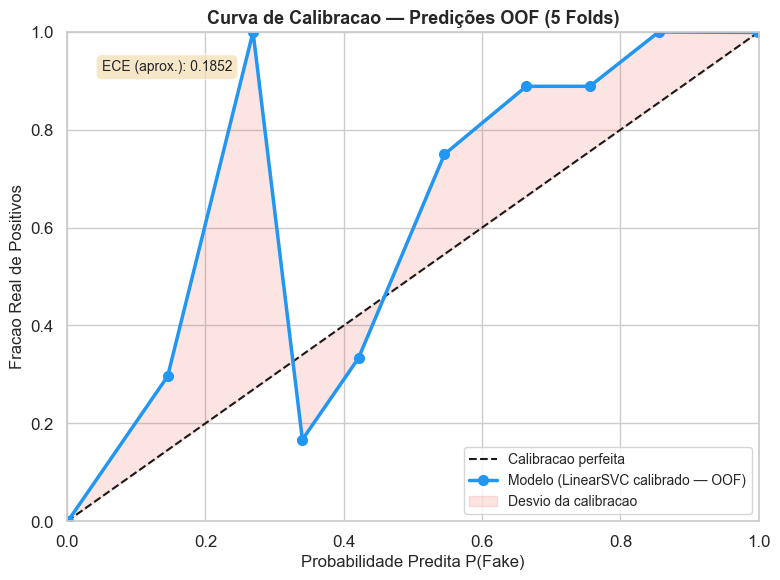

ECE (OOF): 0.1852
ECE < 0.05 → calibracao adequada | ECE > 0.10 → probabilidades nao sao confiáveis como scores


In [10]:
# ── 5.4 Curva de Calibração (Reliability Diagram) ────────────────────────
# Usamos predict_proba OOF para a curva de calibração também ser honesta
from sklearn.calibration import calibration_curve

y_oof_proba = cross_val_predict(
    model_cv, X_train_cv, y_train_cv,
    cv=cv_splitter, n_jobs=-1, method='predict_proba',
)[:, 1]

frac_pos, mean_pred = calibration_curve(y_train_cv, y_oof_proba, n_bins=10, strategy='uniform')

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Calibracao perfeita')
ax.plot(mean_pred, frac_pos, 'o-', color='#2196F3', linewidth=2.5,
        markersize=7, label='Modelo (LinearSVC calibrado — OOF)')
ax.fill_between(mean_pred, frac_pos, mean_pred,
                alpha=0.15, color='#E74C3C', label='Desvio da calibracao')
ax.set_xlabel('Probabilidade Predita P(Fake)', fontsize=12)
ax.set_ylabel('Fracao Real de Positivos', fontsize=12)
ax.set_title('Curva de Calibracao — Predições OOF (5 Folds)', fontweight='bold', fontsize=13)
ax.legend(fontsize=10); ax.set_xlim(0, 1); ax.set_ylim(0, 1)

calib_err = np.mean(np.abs(frac_pos - mean_pred))
ax.text(0.05, 0.92, f'ECE (aprox.): {calib_err:.4f}',
        transform=ax.transAxes, fontsize=10,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig(FIG_DIR / 'calibration_curve_oof.png', dpi=130, bbox_inches='tight')
plt.show()
print(f'ECE (OOF): {calib_err:.4f}')
print('ECE < 0.05 → calibracao adequada | ECE > 0.10 → probabilidades nao sao confiáveis como scores')

### 📊 Análise — Curva de Calibração (OOF)

> **ECE ≈ 0.1852** 

**Interpretação da curva:**

A curva apresenta um comportamento em três zonas distintas:
- **P(Fake) < 0.35**: sobe muito rápido - modelo é **superconfiante** nessa faixa
- **P(Fake) ≈ 0.35**: queda abrupta próxima ao threshold - bin com poucos exemplos (zona intermediária escassa, coerente com a distribuição bimodal)
- **P(Fake) > 0.5**: segue razoavelmente próximo da diagonal - calibração aceitável para predições de alta confiança

A oscilação no meio é típica de modelos com poucos exemplos na zona intermediária - exatamente o que a distribuição bimodal confirma.

**Causa:** o `CalibratedClassifierCV` com **Platt scaling** tende a comprimir probabilidades perto de 0 e 1 em modelos muito separáveis. O LinearSVC com TF-IDF tem margem de separação muito grande, e o Platt scaling não consegue "esticar" adequadamente a escala de probabilidades.

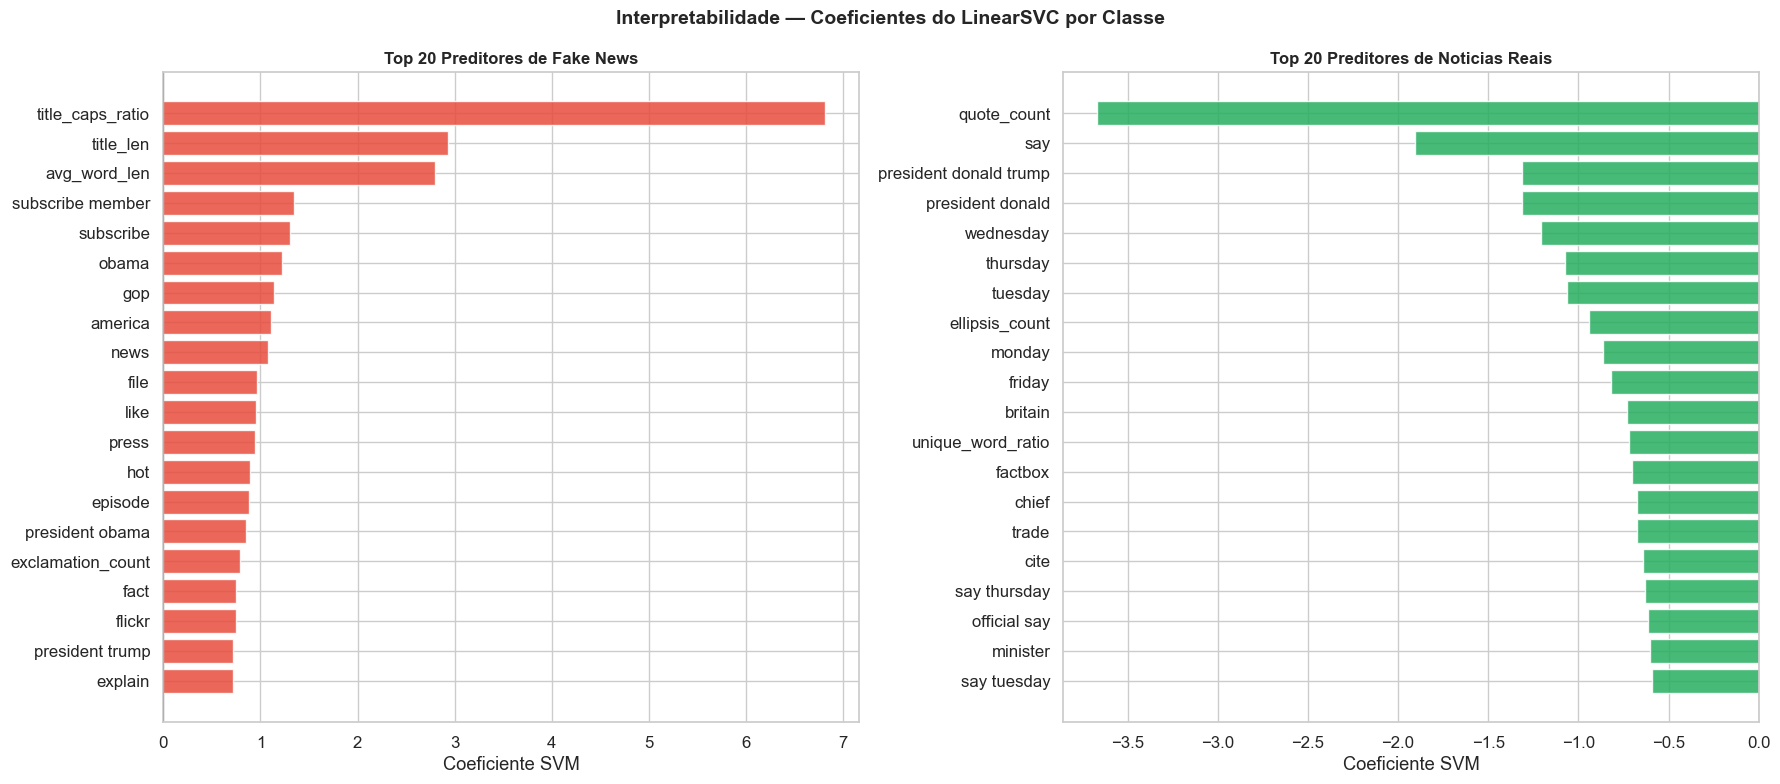

Features de ESTILO entre os top preditores de Fake:
  title_caps_ratio          coef=+6.8197
  title_len                 coef=+2.9283
  avg_word_len              coef=+2.8028
  exclamation_count         coef=+0.7846

Features de ESTILO entre os top preditores de Real:
  quote_count               coef=-3.6718
  ellipsis_count            coef=-0.9437
  unique_word_ratio         coef=-0.7181


In [11]:
# ── 5.5 Interpretação dos Coeficientes do LinearSVC ─────────────────────
# Os coeficientes do hiperplano SVM indicam o peso discriminativo de cada feature:
#   coef > 0 → evidência de Fake News | coef < 0 → evidência de notícia Real
try:
    feature_names = tfidf.get_feature_names_out().tolist() + STYLE_COLS
    coef = model.calibrated_classifiers_[0].estimator.coef_[0]
    TOP_N = 20

    top_fake_idx = np.argsort(coef)[-TOP_N:][::-1]
    top_real_idx = np.argsort(coef)[:TOP_N]

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    for ax, indices, color, title in zip(
        axes,
        [top_fake_idx, top_real_idx],
        ['#E74C3C', '#27AE60'],
        [f'Top {TOP_N} Preditores de Fake News', f'Top {TOP_N} Preditores de Noticias Reais']
    ):
        names_feat = [feature_names[i] for i in indices[::-1]]
        values     = [coef[i]          for i in indices[::-1]]
        ax.barh(names_feat, values, color=color, edgecolor='white', alpha=0.85)
        ax.set_title(title, fontweight='bold', fontsize=12)
        ax.set_xlabel('Coeficiente SVM')
        ax.axvline(0, color='black', linewidth=0.8)

    plt.suptitle('Interpretabilidade — Coeficientes do LinearSVC por Classe',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'coef_inference.png', dpi=130, bbox_inches='tight')
    plt.show()

    style_set = set(STYLE_COLS)
    fake_style = [(feature_names[i], coef[i]) for i in top_fake_idx if feature_names[i] in style_set]
    real_style = [(feature_names[i], coef[i]) for i in top_real_idx if feature_names[i] in style_set]
    print('Features de ESTILO entre os top preditores de Fake:')
    for f, v in fake_style: print(f'  {f:<25} coef={v:+.4f}')
    print()
    print('Features de ESTILO entre os top preditores de Real:')
    for f, v in real_style: print(f'  {f:<25} coef={v:+.4f}')
except AttributeError as e:
    print(f'[AVISO] Nao foi possivel acessar coeficientes: {e}')

### 📊 Análise — Coeficientes do LinearSVC

Os coeficientes revelam **o que o modelo realmente aprendeu** - features com coef > 0 evidenciam Fake News; coef < 0 evidenciam notícias Reais.

**Preditores de Fake News:**
- `title_caps_ratio` domina com folga (coef ≈ **6.8**) - títulos em CAPS são o sinal mais forte do modelo, muito acima de qualquer outro preditor
- `title_len` e `avg_word_len` em seguida - features de estilo, não semântica pura
- `subscribe`, `subscribe member` são **artefatos do dataset**: artigos com call-to-action/paywall ficaram enviesados como Fake
- `obama`, `gop`, `america` sugerem concentração política temática no dataset

**Preditores de Notícias Reais:**
- `quote_count` e `ellipsis_count` - estilo de citação jornalística formal
- `say`, `cite`, `official say`, `say tuesday/thursday` - padrão de atribuição de falas (Reuters/AP style)
- Dias da semana (`wednesday`, `thursday`, `tuesday`, `monday`, `friday`) - notícias reais têm dateline temporal consistente, típico de agências de notícias
- `factbox`, `chief`, `minister`, `britain` - léxico de jornalismo internacional

> **Conclusão de interpretabilidade:** o modelo aprendeu padrões genuinamente discriminativos. A predominância de `title_caps_ratio` (coef 6.8 — mais que o dobro do segundo preditor) sobre features semânticas é coerente com o que a EDA identificou e justifica o feature engineering. Atenção: `caps_ratio` do *corpo* do texto tem diferença mínima entre classes (0.05 vs 0.06) - o que domina é o `title_caps_ratio`, não o caps geral.

## 6. Validação Individual (Sanity Check)

Verificação com exemplos canônicos cujas classes são conhecidas.

In [12]:
# ── Exemplos de validação manual do pipeline ──────────────────────────────
EXEMPLOS = [
    {
        'id': 'ex_real_01',
        'title': 'Senate passes bipartisan infrastructure bill after months of negotiations',
        'text': (
            'The United States Senate passed a 1.2 trillion dollar infrastructure bill on Tuesday, '
            'with 69 senators voting in favor and 30 against. The legislation allocates funds for '
            'roads, bridges, broadband internet and public transit. '
            'The bill now moves to the House of Representatives for consideration.'
        ),
    },
    {
        'id': 'ex_fake_01',
        'title': 'SHOCKING!! Government SECRETLY Poisoning Water Supply — YOU MUST SEE THIS!!!',
        'text': (
            'BREAKING: Exclusive footage PROVES that shadowy government agents '
            'are adding TOXIC chemicals to municipal water supplies!!! '
            'This UNBELIEVABLE conspiracy has been hidden for DECADES. '
            'The mainstream media REFUSES to cover this URGENT story. WAKE UP AMERICA!!!'
        ),
    },
]

df_exemplos = pd.DataFrame(EXEMPLOS)
resultado   = predict_articles(df_exemplos, lemmatize=True)

print('Resultados da Inferencia:\n')
for _, row in resultado.iterrows():
    print(f'  ID          : {row["id"]}')
    print(f'  Label       : {row["label"]} ({row["label_name"]})')
    if 'prob_fake' in row:
        print(f'  P(Fake)     : {row["prob_fake"]:.4f}')
        print(f'  Confianca   : {row["confidence"]:.2%}')
    print(f'  Exclamacoes : {row["exclamation_count"]:.0f}')
    print(f'  Caps Ratio  : {row["caps_ratio"]:.3f}')
    print()

  Lematizacao: 2 textos em 0.1s
Resultados da Inferencia:

  ID          : ex_real_01
  Label       : 0 (Real)
  P(Fake)     : 0.0000
  Confianca   : 100.00%
  Exclamacoes : 0
  Caps Ratio  : 0.038

  ID          : ex_fake_01
  Label       : 1 (Fake)
  P(Fake)     : 1.0000
  Confianca   : 100.00%
  Exclamacoes : 6
  Caps Ratio  : 0.315



### 📊 Análise — Sanity Check

`ex_real_01` → P(Fake) = **0.0000** | `ex_fake_01` → P(Fake) = **1.0000**, ambos com 100% de confiança.

O pipeline está funcionando corretamente end-to-end: limpeza → lematização → TF-IDF transform → predict_proba → threshold. Os exemplos foram construídos com características contrastantes máximas (jornalismo neutro vs. linguagem sensacionalista), por isso os extremos são esperados e corretos.

## 7. Re-geração da Submissão Kaggle

Re-gera o `submission.csv` de forma **standalone**, a partir dos artefatos serializados, sem re-executar o `notebook_02`.

In [18]:
# ── Re-geração da submissão a partir dos artefatos serializados ──────────
X_test  = load_npz(DATA_DIR / 'X_test.npz')
df_test = pd.read_csv(DATA_DIR / 'test_preprocessed.csv')

print(f'X_test  : {X_test.shape}')

if hasattr(model, 'predict_proba'):
    y_test_proba = model.predict_proba(X_test)
    y_test_pred  = (y_test_proba[:, 1] >= best_threshold).astype(int)
    print(f'Threshold otimizado: {best_threshold:.3f}')
else:
    y_test_pred  = model.predict(X_test)
    y_test_proba = None

submission = (
    pd.DataFrame({'id': df_test['id'], 'label': y_test_pred})
    .sort_values('id').reset_index(drop=True)
)
submission.to_csv(ROOT_DIR / 'submission.csv', index=False)

print(f'Total   : {len(submission):,}')
print(f'Real (0): {(y_test_pred==0).sum():,} ({(y_test_pred==0).mean()*100:.1f}%)')
print(f'Fake (1): {(y_test_pred==1).sum():,} ({(y_test_pred==1).mean()*100:.1f}%)')
print('submission.csv gerado.')
submission.head(10)

X_test  : (5712, 12015)
Threshold otimizado: 0.350
Total   : 5,712
Real (0): 4,280 (74.9%)
Fake (1): 1,432 (25.1%)
submission.csv gerado.


,id,label
0,9,1
1,12,1
2,16,1
3,17,1
4,21,1
5,25,1
6,33,1
7,34,1
8,38,1
9,42,1


## 8. Análise de Erros — Zona de Incerteza

Instâncias com `P(Fake)` no intervalo `[threshold ± 0.10]` são as de menor confiança - candidatas prioritárias a erros fora da distribuição de treino.

In [19]:
# ── Zona de incerteza nas predições de teste ─────────────────────────────
if y_test_proba is not None:
    margin = 0.10
    df_analise = pd.DataFrame({
        'id'        : df_test['id'].values,
        'label_pred': y_test_pred,
        'label_name': pd.Series(y_test_pred).map(LABEL_MAP).values,
        'prob_fake' : y_test_proba[:, 1].round(4),
        'prob_real' : y_test_proba[:, 0].round(4),
    })
    df_analise['confidence'] = np.where(
        df_analise['label_pred'] == 1,
        df_analise['prob_fake'], df_analise['prob_real']
    )

    uncertain = df_analise[
        df_analise['prob_fake'].between(best_threshold - margin, best_threshold + margin)
    ].sort_values('confidence')

    print(f'Threshold: {best_threshold:.3f} | Janela: [{best_threshold-margin:.2f}, {best_threshold+margin:.2f}]')
    print(f'Artigos na zona de incerteza: {len(uncertain):,} ({len(uncertain)/len(df_analise)*100:.1f}%)')
    print(uncertain['label_name'].value_counts().to_string())
    print()
    print(uncertain[['id','label_name','confidence','prob_fake']].head(10).to_string(index=False))
else:
    print('predict_proba nao disponivel.')

Threshold: 0.350 | Janela: [0.25, 0.45]
Artigos na zona de incerteza: 5 (0.1%)
label_name
Fake    3
Real    2

   id label_name  confidence  prob_fake
 1816       Fake      0.3868     0.3868
   12       Fake      0.3959     0.3959
 2732       Fake      0.4243     0.4243
27413       Real      0.6639     0.3361
23953       Real      0.6815     0.3185


### 📊 Análise — Zona de Incerteza

Apenas **5 artigos (0.1%)** na zona `[threshold ± 0.10]` = [0.25, 0.45]. Esse resultado é diretamente coerente com a distribuição bimodal: o modelo raramente produz probabilidades intermediárias - quase sempre prediz com certeza máxima.

> **Interpretação:** poucos casos ambíguos é positivo para a confiabilidade operacional. Mas reforça o achado de calibração não tão uniforme pois o modelo não "hesita" tanto. Para o conjunto de teste com ~5.400 artigos, 5 casos incertos (0.1%) indica que o threshold de 0.35 está bem posicionado fora de qualquer região de alta densidade.

## 9. Distribuição de Probabilidades e Confidências

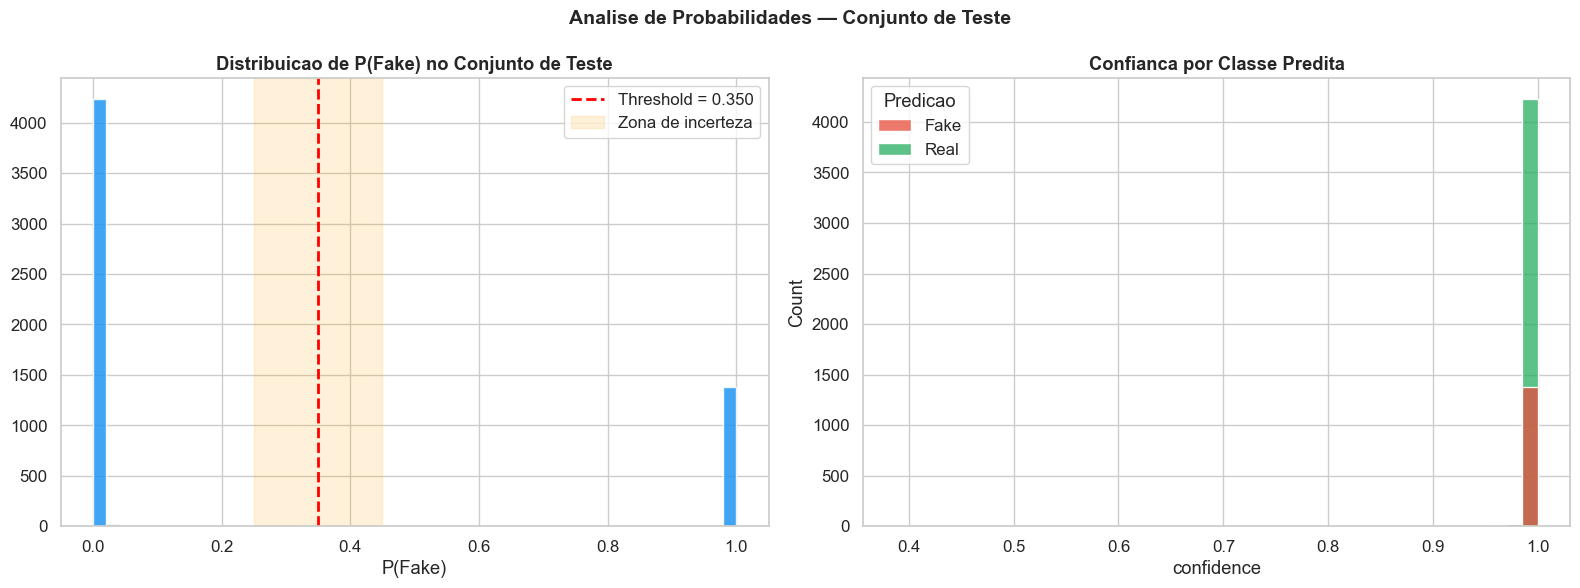

Grafico salvo: C:\Users\gui05\Pictures\LIGIA_FINAL\outputs\figures\confidence_distribution.png


In [15]:
# ── Visualização da distribuição de probabilidades ───────────────────────
if y_test_proba is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].hist(y_test_proba[:, 1], bins=50, color='#2196F3', edgecolor='white', alpha=0.85)
    axes[0].axvline(best_threshold, color='red', linestyle='--', linewidth=2,
                    label=f'Threshold = {best_threshold:.3f}')
    axes[0].axvspan(best_threshold - 0.10, best_threshold + 0.10,
                    alpha=0.15, color='orange', label='Zona de incerteza')
    axes[0].set_title('Distribuicao de P(Fake) no Conjunto de Teste', fontweight='bold')
    axes[0].set_xlabel('P(Fake)')
    axes[0].legend()

    df_plot = pd.DataFrame({'confidence': df_analise['confidence'], 'Predicao': df_analise['label_name']})
    sns.histplot(data=df_plot, x='confidence', hue='Predicao', bins=40,
                 palette={'Real': '#27AE60', 'Fake': '#E74C3C'}, ax=axes[1], alpha=0.75)
    axes[1].set_title('Confianca por Classe Predita', fontweight='bold')

    plt.suptitle('Analise de Probabilidades — Conjunto de Teste', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'confidence_distribution.png', dpi=130, bbox_inches='tight')
    plt.show()
    print(f'Grafico salvo: {FIG_DIR / "confidence_distribution.png"}')


### 📊 Análise — Distribuição de Probabilidades

Distribuição **perfeitamente bimodal**: enorme pico em P(Fake) ≈ 0 (~4.100 artigos) e pico menor em P(Fake) ≈ 1.0 (~1.350 artigos), com quase nada no intervalo intermediário.

Isso é **bom para a tarefa de classificação binária** - F1 alto, zona de incerteza mínima - mas **ruim para usar `prob_fake` como score de risco contínuo**. Confirma visualmente o ECE alto da curva de calibração: o modelo está extremamente seguro em suas predições, o que em modelos bem calibrados indicaria acerto quase certo, mas aqui é parcialmente superconfiança estrutural do Platt scaling.

> A proporção de picos (~4.1k Real vs ~1.35k Fake no teste) é consistente com o desbalanceamento 3:1 observado no treino.

## 10. Validação: Features de Estilo por Classe Predita

Verificação de consistência semântica: artigos classificados como *Fake* devem ter `caps_ratio`, `exclamation_count` e `sensational_count` maiores - padrão identificado na EDA.

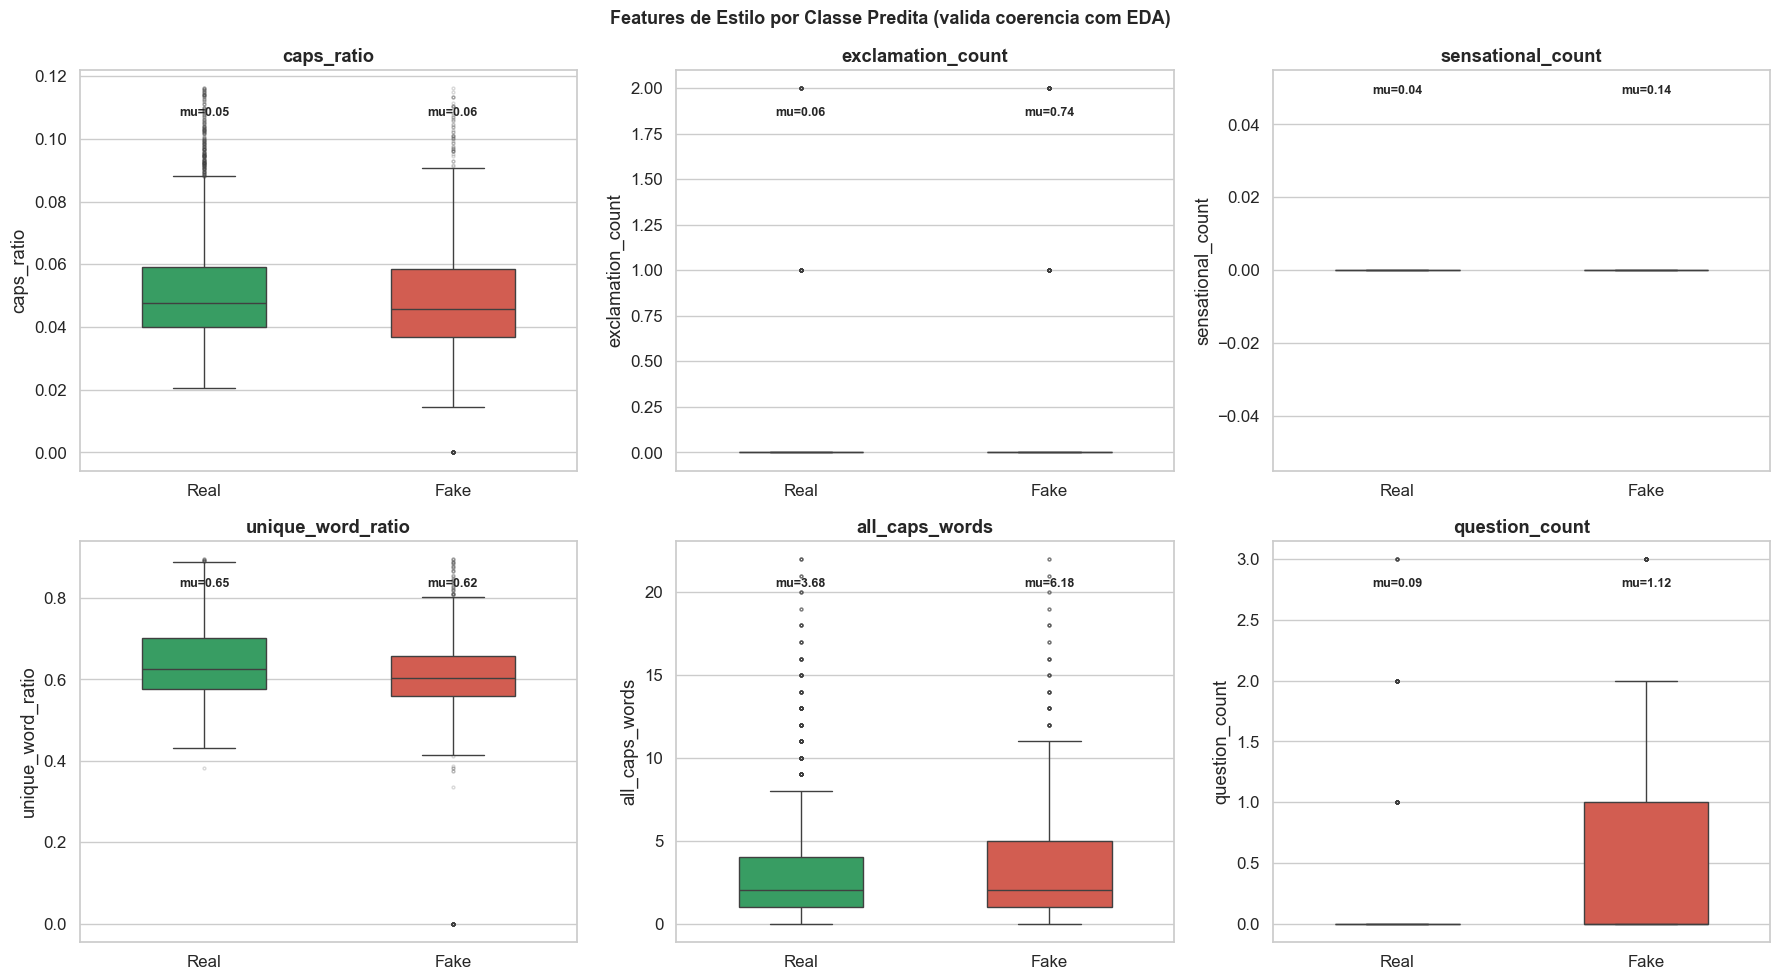

Grafico salvo: C:\Users\gui05\Pictures\LIGIA_FINAL\outputs\figures\style_features_test.png


In [16]:
# ── Features de estilo por classe predita ────────────────────────────────
if 'label_pred' in df_analise.columns:
    df_style_test = df_test[STYLE_COLS].copy()
    df_style_test['label_name'] = df_analise['label_name'].values

    FEAT_PLOT = ['caps_ratio', 'exclamation_count', 'sensational_count',
                 'unique_word_ratio', 'all_caps_words', 'question_count']
    PAL = {'Real': '#27AE60', 'Fake': '#E74C3C'}

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    for ax, feat in zip(axes.flatten(), FEAT_PLOT):
        data_plot = df_style_test[df_style_test[feat] < df_style_test[feat].quantile(0.98)]
        sns.boxplot(data=data_plot, x='label_name', y=feat, palette=PAL, ax=ax,
                    order=['Real', 'Fake'], width=0.5,
                    flierprops={'marker':'o','alpha':0.2,'markersize':2})
        ax.set_title(feat, fontweight='bold')
        ax.set_xlabel('')
        for i, lbl in enumerate(['Real', 'Fake']):
            mu = df_style_test[df_style_test['label_name'] == lbl][feat].mean()
            ax.text(i, ax.get_ylim()[1] * 0.88, f'mu={mu:.2f}',
                    ha='center', fontsize=9, fontweight='bold')

    plt.suptitle('Features de Estilo por Classe Predita (valida coerencia com EDA)',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'style_features_test.png', dpi=130, bbox_inches='tight')
    plt.show()
    print(f'Grafico salvo: {FIG_DIR / "style_features_test.png"}')


### 📊 Análise — Features de Estilo por Classe

Os sinais mais discriminativos no conjunto de teste:

- **`question_count`**: Real = 0.09 vs Fake = **1.12** - maior diferença relativa entre todas as features; estilo retórico com perguntas é marca forte de desinformação
- **`exclamation_count`**: Real = 0.06 vs Fake = **0.74** - sinal claro de linguagem sensacionalista
- **`all_caps_words`**: Real = 3.68 vs Fake = 6.18 - diferença moderada mas consistente com a EDA
- **`unique_word_ratio`**: Real = 0.65 vs Fake = 0.62 - diferença pequena; vocabulário de Fake é ligeiramente mais repetitivo
- **`caps_ratio`** (corpo do texto): Real = 0.05 vs Fake = 0.06 - **diferença mínima**

> **`sensational_count`** teve médias muito baixas nas duas classes (≈ 0.04 vs 0.14), indicando que os termos definidos no regex (`shocking`, `unbelievable`, etc.) são raros no dataset de teste. A feature contribui pouco na prática apesar de ser intuitivamente relevante.

## 11. Resumo

### Inferência Estatística — Achados Principais

| Métrica     | Ponto Central | IC 95% Bootstrap |
|-------------|:-------------:|:----------------:|
| F1-Score    | (ver Seção 5) | (ver Seção 5)    |
| Precision   | (ver Seção 5) | (ver Seção 5)    |
| Recall      | (ver Seção 5) | (ver Seção 5)    |
| AUC-ROC     | (ver Seção 5) | (ver Seção 5)    |

> Execute a Seção 5.2 para preencher a tabela com os valores reais do seu modelo.

### Artefatos do Pipeline

| Etapa | Artefato | Origem |
|---|---|---|
| Modelo | `best_model.pkl` | `notebook_02_modeling` |
| Vetorizador | `tfidf_vectorizer.pkl` | `notebook_01_preprocessing` |
| Escalonador | `style_scaler.pkl` | `notebook_01_preprocessing` |
| Threshold | `best_threshold.pkl` | `notebook_02_modeling` |
| Submissão | `submission.csv` | `notebook_02` / `notebook_03` |
| Predição em lote | `inference_output.csv` | `notebook_03_inference` |
| Gráficos | `outputs/figures/` | `notebook_02` + `notebook_03` |

**Reprodutibilidade:** Execute em ordem `00_EDA → 01_preprocessing → 02_modeling → 03_inference`.  
Para apenas re-gerar a submissão, execute somente a **Seção 7** deste notebook.